# Анализ результатов A/B-теста интернет-магазина

Вместе с отделом маркетинга была выполнена подготовка списка гипотез для увеличения выручки.
 

#### Цель проекта:
Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

#### Описание данных:
1. Данные для первой части  
Файл /datasets/hypothesis.csv:
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

2. Данные для второй части  
Файл /datasets/orders.csv:  
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv:  
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

#### План анализа:
1. Проведем приоритезацию гипотез.
2. Проведем анализ A/B-теста:
    * Построим график кумулятивной выручки по группам;
    * Построим график кумулятивного среднего чека по группам;
    * Построим график относительного изменения кумулятивного среднего чека группы B к группе A;
    * Построим график кумулятивного среднего количества заказов на посетителя по группам;
    * Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A;
    * Построим точечный график количества заказов по пользователям;
    * Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Определим границу для определения аномальных пользователей;
    * Построим точечный график стоимостей заказов;
    * Посчитаем 95-й и 99-й перцентили стоимости заказов. Определим границу для определения аномальных заказов;
    * Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным;
    * Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным;
    * Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным;
    * Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным;
    * Сделаем выводы по результатам теста.
    
### 1 Приоритезация гипотез
Для начала импортируем все нужные библиотеки.

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings
import scipy.stats as stats

Загрузим данные:

In [2]:
try:
    data = pd.read_csv('/datasets/hypothesis.csv') # откроем файл,
except:
    data = pd.read_csv('https://code.s3.yandex.net//datasets/hypothesis.csv') # если не удалось, возьмем данные с сайта

Изучим первые 10 строк:

In [3]:
pd.options.display.max_colwidth = 400
data.head(10)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Приведем названия столбцов к общепринятому виду:

In [4]:
data.columns = data.columns.str.lower()

Проверим результат и изучим типы данных:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


С типами все впорядке.  

Приоритезация гипотез нужна для того, чтобы выбрать какие гипотезы проверять в первую очередь. Существует множество способов приоритезации гипотез, попробуем несколько из них.

Применим фреймворк `ICE` для приоритизации гипотез, он содержит следующие параметры:
* *Impact* — насколько сильно изменение повлияет на пользователей, их опыт и удовлетворение от продукта;
* *Confidence* — насколько вы уверены, что это изменение повлияет на пользователей именно так; 
* *Efforts* — сколько стоит протестировать эту гипотезу. 

In [6]:
data['ICE'] = data['impact'] * data['confidence'] / data['efforts'] # посчитаем приоритет по формуле

data.loc[:, ['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False) # отсортируем гипотезы по убыванию приоритета

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее приоритетными оказались гипотезы 8, 0 и 7.

Применим фреймворк `RICE` для приоритизации гипотез. В отличие от фреймворка `ICE`, тут добавляется параметр *Reach* — скольких пользователей затронет изменение, которое вы хотите внести.

In [7]:
data['RICE'] = data['reach'] * data['impact'] * data['confidence'] / data['efforts'] # посчитаем приоритет по формуле

data.loc[:, ['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False) # отсортируем гипотезы по убыванию приоритета

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Гипотезы **7** и **0** остались в лидерах, а вот **8** гипотеза по приоритету сильно опустилась вниз. Вместо нее в лидерах оказалась **2** гипотеза.

Дело в том, что у гипотез **7** и **2** высокое значение `reach` (кол-во пользователей, которое затронет изменение), тогда как у **8** гипотезы оно минимальное. Гипотеза **0** выигрывает по приоритету тем, что у нее высокий параметр `Impact` (показывает, насколько сильно изменение повлияет на охваченных пользователей).

### 2 Анализ A/B-теста

Для начала загрузим и изучим данные.

#### 2.1 Загрузка и предобработка данных

In [8]:
try:
    orders = pd.read_csv('/datasets/orders.csv') # откроем файлы,
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net//datasets/orders.csv') # если не удалось, возьмем данные с сайта
    visitors = pd.read_csv('https://code.s3.yandex.net//datasets/visitors.csv')

Изучим данные в датафрейме `orders`:

In [9]:
orders.head(10) # изучим первые 10 строк

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
5,182168103,935554773,2019-08-15,2210,B
6,398296753,2900797465,2019-08-15,1860,B
7,2626614568,78758296,2019-08-15,1044,A
8,1576988021,295230930,2019-08-15,13710,A
9,1506739906,1882260405,2019-08-15,1855,B


In [10]:
orders.info() # изучим информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Данным требуется предобработка:
1. Необходимо привести названия столбцов к общепринятым
2. Привести столбец `date` к типу `datetime`.

In [11]:
orders = orders.rename(columns={'transactionId': 'transaction_id', 'visitorId': 'visitor_id'}) #поменяем названия столбцов

In [12]:
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d') # поменяем тип данных столбца date
orders.info() # проверим результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   transaction_id  1197 non-null   int64         
 1   visitor_id      1197 non-null   int64         
 2   date            1197 non-null   datetime64[ns]
 3   revenue         1197 non-null   int64         
 4   group           1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


Изучим данные в датафрейме `visitors`:

In [13]:
visitors.head(10) # изучим первые 10 строк

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
5,2019-08-06,A,667
6,2019-08-07,A,644
7,2019-08-08,A,610
8,2019-08-09,A,617
9,2019-08-10,A,406


In [14]:
visitors.info() # изучим информацию о данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Здесь нужно только привести тип столбца `date` к `datetime`:

In [15]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d') # поменяем тип данных столбца date
visitors.info() # проверим результат

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


Проверим за какой отрезок времени представлены данные.

In [16]:
display('Минимальная дата заказа:', orders['date'].min())

'Минимальная дата заказа:'

Timestamp('2019-08-01 00:00:00')

In [17]:
display('Максимальная дата заказа:', orders['date'].max())

'Максимальная дата заказа:'

Timestamp('2019-08-31 00:00:00')

Проверим данные на дубликаты:

In [18]:
visitors.duplicated().sum()

0

In [19]:
orders.duplicated().sum()

0

Дубликатов не обнаружено. 

Проверим данные на корректность: есть ли пользователи, которые одновременно находятся в двух группах.

In [20]:
# отберем пользователей, которые состоят более чем в одной группе
group_orders = orders.groupby('visitor_id')['group'].nunique().reset_index()
group_orders = group_orders[group_orders['group'] >1]
group_orders.head(10)

,visitor_id,group
2,8300375,2
44,199603092,2
51,232979603,2
55,237748145,2
66,276558944,2
84,351125977,2
97,393266494,2
114,457167155,2
119,471551937,2
122,477780734,2


Нашлись, пользователи, которые одновременно состоят в двух группах, соответственно результаты теста будут некорректны.
Удалим таких пользователей.

In [21]:
# удалим пользователей, состоящих одновременно в двух круппах
orders = orders[~ orders['visitor_id'].isin(group_orders['visitor_id'])]

# проверим результат
group_orders_new = orders.groupby('visitor_id')['group'].nunique().reset_index()
group_orders_new[group_orders_new['group'] >1]['group'].count()

0

Теперь можно приступать непосредственно к анализу A/B-теста.

#### 2.2 Анализ A/B-теста

Создадим датафрейм `dates_groups` с уникальными парами значений `date` и `group`, таблицы `orders`. Избавимся от дубликатов методом `drop_duplicates()`.

In [22]:
dates_groups = orders[['date', 'group']].drop_duplicates()

Создадим переменную `orders_aggregated`, содержащую:
* дату;
* группу A/B-теста;
* число уникальных заказов в группе теста по указанную дату включительно;
* число уникальных пользователей, совершивших хотя бы 1 заказ в группе теста по указанную дату включительно;
* суммарную выручку заказов в группе теста по указанную дату включительно.

In [23]:
orders_aggregated = dates_groups.apply(
    lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
'date' : 'max',
'group' : 'max',
'transaction_id' : pd.Series.nunique,
'visitor_id' : pd.Series.nunique,
'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])
orders_aggregated = orders_aggregated.sort_values(by=['date', 'group']) # отсортируем по дате и группе

orders_aggregated # проверим результат

,date,group,transaction_id,visitor_id,revenue
55,2019-08-01,A,23,19,142779
66,2019-08-01,B,17,17,59758
175,2019-08-02,A,42,36,234381
173,2019-08-02,B,40,39,221801
291,2019-08-03,A,66,60,346854
...,...,...,...,...,...
533,2019-08-29,B,510,490,4746610
757,2019-08-30,A,460,437,3311413
690,2019-08-30,B,531,511,4955833
958,2019-08-31,A,468,445,3364656


Создадим переменную `visitors_aggregated`, содержащую:
* дату;
* группу A/B-теста;
* количество уникальных посетителей в группе теста по указанную дату включительно.

In [24]:
visitors_aggregated = dates_groups.apply(
    lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
'date' : 'max', 
'group' : 'max', 
'visitors' : 'sum'}), axis=1).sort_values(by=['date','group']) 

visitors_aggregated = visitors_aggregated.sort_values(by=['date', 'group']) # отсортируем по дате и группе

visitors_aggregated # проверим результат

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
533,2019-08-29,B,17708
757,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Создадим переменную `cumulative_data`, объединив `orders_aggregated` и `visitors_aggregated` по колонкам `date`, `group` методом `merge()`.

In [25]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], right_on=['date', 'group'])

cumulative_data # проверим результат

,date,group,transaction_id,visitor_id,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845
...,...,...,...,...,...,...
57,2019-08-29,B,510,490,4746610,17708
58,2019-08-30,A,460,437,3311413,18037
59,2019-08-30,B,531,511,4955833,18198
60,2019-08-31,A,468,445,3364656,18736


Присвоим столбцам cumulative_data другие названия:

In [26]:
cumulative_data.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulative_data.head() # проверим результат

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Создадим переменные `cumulative_revenue_A` и `cumulative_revenue_B`, в которых сохраним данные о датах, выручке и числе заказов в группах `A` и `B`.

In [27]:
cumulative_revenue_A = cumulative_data[cumulative_data['group']=='A'][['date','revenue', 'orders']]
cumulative_revenue_B = cumulative_data[cumulative_data['group']=='B'][['date','revenue', 'orders']]

display(cumulative_revenue_A.head())  # проверим результат
cumulative_revenue_B.head()

,date,revenue,orders
0,2019-08-01,142779,23
2,2019-08-02,234381,42
4,2019-08-03,346854,66
6,2019-08-04,388030,77
8,2019-08-05,474413,99


,date,revenue,orders
1,2019-08-01,59758,17
3,2019-08-02,221801,40
5,2019-08-03,288850,54
7,2019-08-04,385740,68
9,2019-08-05,475648,89


Построим график кумулятивной выручки по дням по группам.

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(18109.0, 0, '2019-08-01'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18117.0, 0, '2019-08-09'),
  Text(18121.0, 0, '2019-08-13'),
  Text(18125.0, 0, '2019-08-17'),
  Text(18129.0, 0, '2019-08-21'),
  Text(18133.0, 0, '2019-08-25'),
  Text(18137.0, 0, '2019-08-29'),
  Text(18140.0, 0, '2019-09-01')])

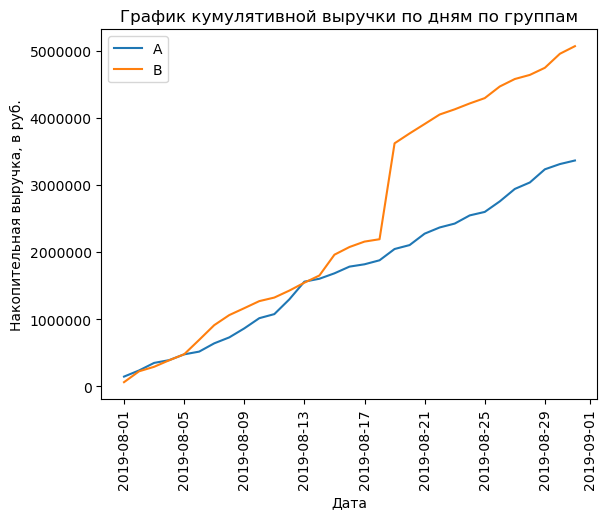

In [28]:
plt.ticklabel_format(style='plain')
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по дням по группам')
plt.xlabel('Дата')
plt.ylabel('Накопительная выручка, в руб.')
plt.xticks(rotation=90)

Кумулятивная выручка группы `B` выше на протяжении всего времени теста, но увеличивается на всем протяжении теста, собственно, как и в группе `A`.

Для каждой группы построим график кумулятивного среднего чека по дням.

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(18109.0, 0, '2019-08-01'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18117.0, 0, '2019-08-09'),
  Text(18121.0, 0, '2019-08-13'),
  Text(18125.0, 0, '2019-08-17'),
  Text(18129.0, 0, '2019-08-21'),
  Text(18133.0, 0, '2019-08-25'),
  Text(18137.0, 0, '2019-08-29'),
  Text(18140.0, 0, '2019-09-01')])

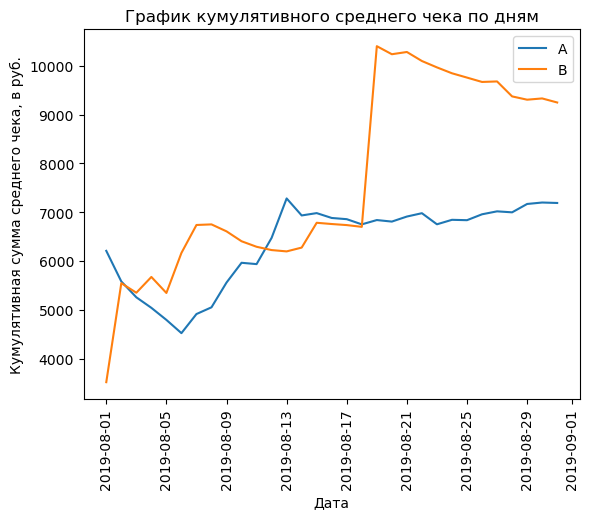

In [29]:
plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue']/cumulative_revenue_A['orders'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue']/cumulative_revenue_B['orders'], label='B')
plt.legend()
plt.title('График кумулятивного среднего чека по дням')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная сумма среднего чека, в руб.')
plt.xticks(rotation=90)

Средний чек группы `B` больше почти на всем протяжении теста, но примерно в середине теста значение группы `B`резко растет, возможно на это повлияли выбросы.

Объединим таблицы `cumulative_revenue_A` и `cumulative_revenue_B` методом `merge()`.

In [30]:
merged_cumulative_revenue = cumulative_revenue_A.merge(cumulative_revenue_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_revenue.head() # проверим результат

,date,revenueA,ordersA,revenueB,ordersB
0,2019-08-01,142779,23,59758,17
1,2019-08-02,234381,42,221801,40
2,2019-08-03,346854,66,288850,54
3,2019-08-04,388030,77,385740,68
4,2019-08-05,474413,99,475648,89


Построим график относительного различия кумулятивного среднего чека группы `B` к группе `A`.

Добавим пунктирную линию оси `X` (значение оси `Y = 0`).

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(18109.0, 0, '2019-08-01'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18117.0, 0, '2019-08-09'),
  Text(18121.0, 0, '2019-08-13'),
  Text(18125.0, 0, '2019-08-17'),
  Text(18129.0, 0, '2019-08-21'),
  Text(18133.0, 0, '2019-08-25'),
  Text(18137.0, 0, '2019-08-29'),
  Text(18140.0, 0, '2019-09-01')])

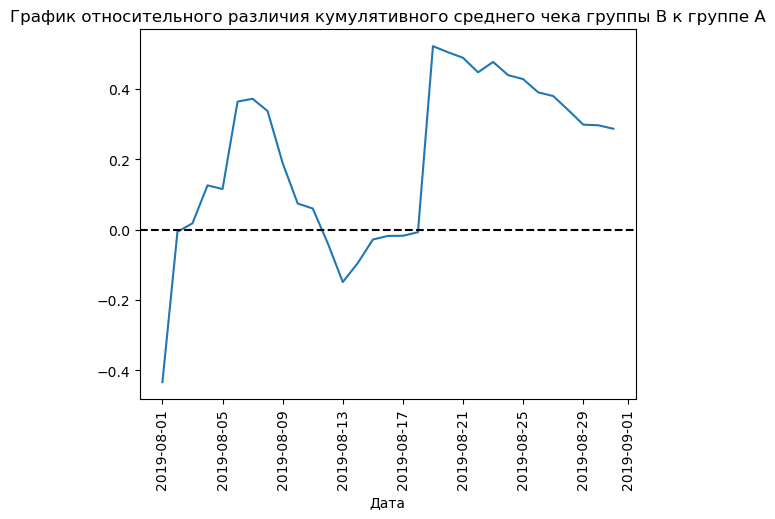

In [31]:
plt.plot(merged_cumulative_revenue['date'], (merged_cumulative_revenue['revenueB']/merged_cumulative_revenue['ordersB'])/(merged_cumulative_revenue['revenueA']/merged_cumulative_revenue['ordersA'])-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного различия кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.xticks(rotation=90)

Средние значения менялись резко и несколько раз на протяжении теста, возможно в этот момент были совершены аномальные заказы.

Добавим в `cumulative_dData` столбец `conversion` c отношением числа заказов к количеству пользователей в указанной группе в указанный день. Получим это значение, разделив кол-во заказов на кол-во посетителей в этот день.

In [32]:
cumulative_data['conversion'] = cumulative_data['orders']/cumulative_data['visitors']
cumulative_data.head() # проверим результат

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
1,2019-08-01,B,17,17,59758,713,0.023843
2,2019-08-02,A,42,36,234381,1338,0.031390
3,2019-08-02,B,40,39,221801,1294,0.030912
4,2019-08-03,A,66,60,346854,1845,0.035772


Создадим переменные `cumulative_data_A` и `cumulative_data_B`, в которых сохраните данные о заказах в сегментах `A` и `B` соответственно.

In [33]:
# отделяем данные по группе A
cumulative_data_A = cumulative_data[cumulative_data['group']=='A']

# отделяем данные по группе B
cumulative_data_B = cumulative_data[cumulative_data['group']=='B']

display(cumulative_data_A.head()) # проверим результат
cumulative_data_B.head()

,date,group,orders,buyers,revenue,visitors,conversion
0,2019-08-01,A,23,19,142779,719,0.031989
2,2019-08-02,A,42,36,234381,1338,0.031390
4,2019-08-03,A,66,60,346854,1845,0.035772
6,2019-08-04,A,77,71,388030,2562,0.030055
8,2019-08-05,A,99,92,474413,3318,0.029837


,date,group,orders,buyers,revenue,visitors,conversion
1,2019-08-01,B,17,17,59758,713,0.023843
3,2019-08-02,B,40,39,221801,1294,0.030912
5,2019-08-03,B,54,53,288850,1803,0.029950
7,2019-08-04,B,68,66,385740,2573,0.026428
9,2019-08-05,B,89,87,475648,3280,0.027134


Построим график кумулятивного среднего количества заказов на посетителя по дням по группам.

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(18109.0, 0, '2019-08-01'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18117.0, 0, '2019-08-09'),
  Text(18121.0, 0, '2019-08-13'),
  Text(18125.0, 0, '2019-08-17'),
  Text(18129.0, 0, '2019-08-21'),
  Text(18133.0, 0, '2019-08-25'),
  Text(18137.0, 0, '2019-08-29'),
  Text(18140.0, 0, '2019-09-01')])

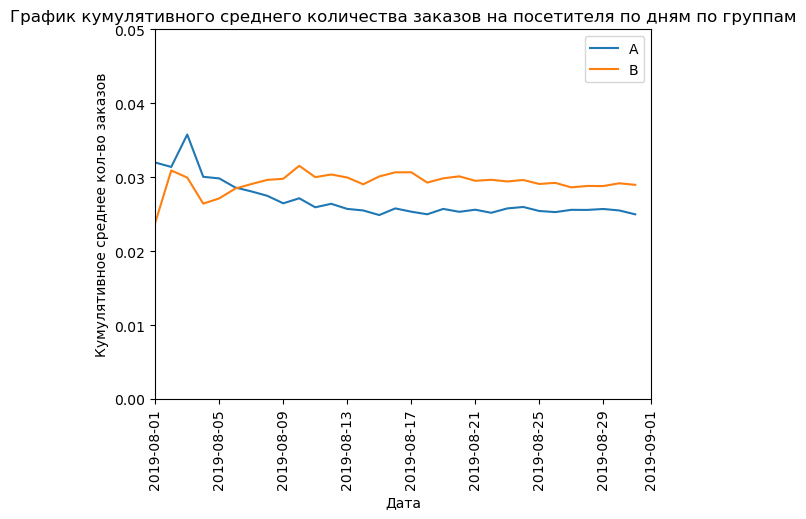

In [34]:
plt.plot(cumulative_data_A['date'], cumulative_data_A['conversion'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по дням по группам')
plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее кол-во заказов')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0, 0.05])
plt.xticks(rotation=90)

По графику видно, что в группе `B` пользователи делали больше заказов (на каждого пользователя), чем в группе `A` практически на всем протяжении теста. Конверсии немного колебались в начале, но к концу графика зафиксировались.

Объединим таблицы `cumulative_data_A` и `cumulative_data_B` методом `merge()`.

In [35]:
merged_cumulative_conversions = cumulative_data_A[['date','conversion']].merge(cumulative_data_B[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
merged_cumulative_conversions.head() # проверим результат

,date,conversionA,conversionB
0,2019-08-01,0.031989,0.023843
1,2019-08-02,0.031390,0.030912
2,2019-08-03,0.035772,0.029950
3,2019-08-04,0.030055,0.026428
4,2019-08-05,0.029837,0.027134


Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы `B` к группе `A`.

Добавим пунктирную линию оси `X` чёрного цвета со значением оси `Y = 0`. И ещё одну линию оси `X` серого цвета со значением оси `Y = 0.2`.

(array([18109., 18113., 18117., 18121., 18125., 18129., 18133., 18137.,
        18140.]),
 [Text(18109.0, 0, '2019-08-01'),
  Text(18113.0, 0, '2019-08-05'),
  Text(18117.0, 0, '2019-08-09'),
  Text(18121.0, 0, '2019-08-13'),
  Text(18125.0, 0, '2019-08-17'),
  Text(18129.0, 0, '2019-08-21'),
  Text(18133.0, 0, '2019-08-25'),
  Text(18137.0, 0, '2019-08-29'),
  Text(18140.0, 0, '2019-09-01')])

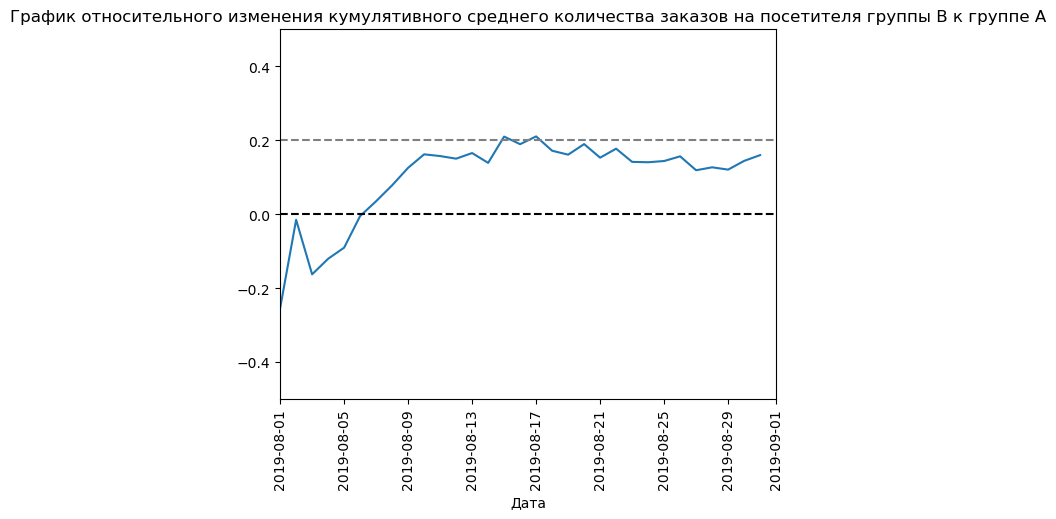

In [36]:
plt.plot(merged_cumulative_conversions['date'], merged_cumulative_conversions['conversionB']/merged_cumulative_conversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), -0.5, 0.5])
plt.xticks(rotation=90)

В начале теста группа `B` значительно проигрывала группе `A`, затем вырвалась вперёд. Потом её конверсия снова падала, но теперь постепенно растёт.  
В целом отношение конверсии ещё не установилось, и сейчас делать какие-либо выводы по тесту нельзя.

Далее проаналазируем аномалии.

Для начала найдем число заказов по каждому пользователю.

In [37]:
orders_by_users = (
    orders.groupby('visitor_id', as_index=False) # сгруппируем данные по пользователям
    .agg({'transaction_id': 'nunique'}) # подсчитаем кол-во заказов
)
orders_by_users.columns = ['visitor_id', 'orders']
orders_by_users.sort_values(by='orders', ascending=False).head(10) # проверим результат

,visitor_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Есть пользователи, которые сделали и 11 заказов. Визуализируем данные для удоства восприятия.

Построим гистограмму распределения числа заказов по пользователям.

Text(0, 0.5, 'Количество пользователей')

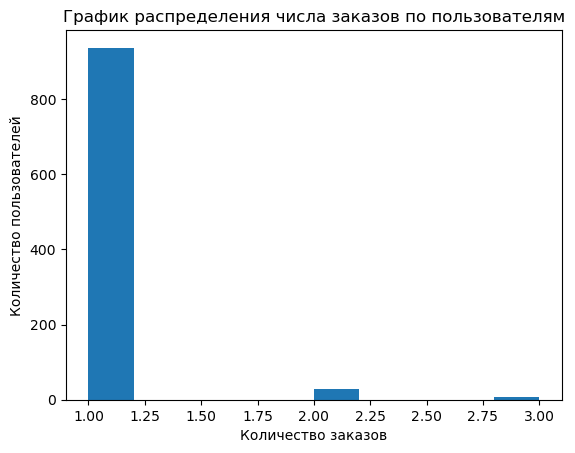

In [38]:
plt.hist(orders_by_users['orders'])
plt.title('График распределения числа заказов по пользователям')
plt.xlabel('Количество заказов')
plt.ylabel('Количество пользователей')

По графику видно, что большая часть пользователей оформила заказ 1-2 раза, но есть и те, кто заказывал 6 раз. По такому графику сложно сказать какое кол-во заказов можно считать аномальным. Построим точечный график.

Text(0, 0.5, 'Количество заказов')

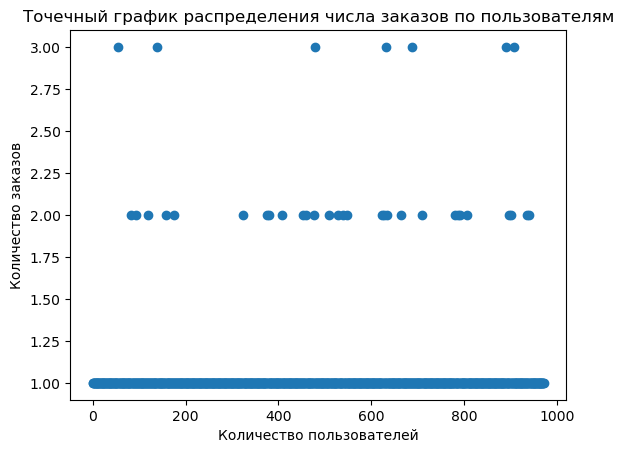

In [39]:
x_values = pd.Series(range(0,len(orders_by_users))) # зададим значения для оси x

plt.scatter(x_values, orders_by_users['orders']) # построим график

plt.title('Точечный график распределения числа заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')

По этому графику лучше видно, что есть пользователи, которые cделали 2 и 3 заказа, их точная доля не ясна — непонятно, считать их аномалиями или нет. 

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [40]:
print('95 и 99-й перцентили соответственно равны:', np.percentile(orders_by_users['orders'], [95, 99]))

95 и 99-й перцентили соответственно равны: [1. 2.]


Не более 1%  пользователей сделали больше 2 заказов, и не более 5% пользователей сделали больше 1 заказов. Будем считать аномальными кол-во заказов больше 1.

Построим точечный график стоимостей заказов.

Text(0, 0.5, 'Стоимость заказов')

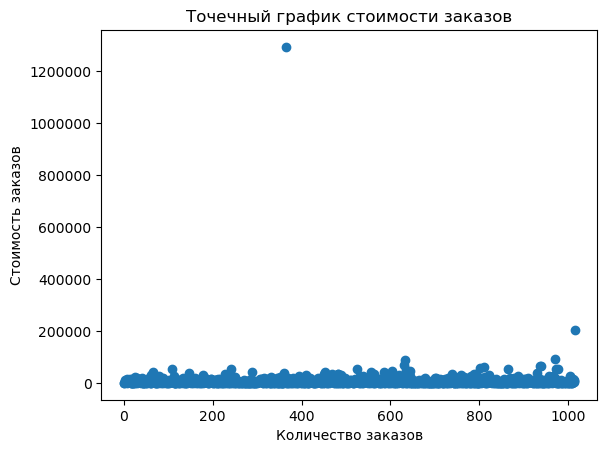

In [41]:
plt.ticklabel_format(style='plain')
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 

plt.title('Точечный график стоимости заказов')
plt.xlabel('Количество заказов')
plt.ylabel('Стоимость заказов')

Выделяются только два заказа с аномально большими цифрами.

Посчитаем 95-й и 99-й перцентили стоимости заказов.

In [42]:
print('95 и 99-й перцентили соответственно равны:', np.percentile(orders['revenue'], [95, 99]))

95 и 99-й перцентили соответственно равны: [26785. 53904.]


Не более 1% пользователей сделали заказы на сумму более 53 904 руб., и не более 5% пользователей сделали заказы на сумму более 26 785 руб. Будем считать аномальными кол-во заказов, чья сумма превышает 26 785.

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.

Сформулируем гипотезы.  
*H0: различий в среднем количестве заказов между группами нет.*  
*H1: различия в среднем между группами есть.*

Начнём с подготовки данных.

In [43]:
# отеберем кол-во посетителей в группе А по дням
visitors_A_daily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitors_A_daily.columns = ['date', 'visitors_per_date_A']

# посчитаем общее кол-во посетителей в группе А
visitors_A_cummulative = visitors_A_daily.apply(
    lambda x: visitors_A_daily[visitors_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_A': 'sum'}
    ),
    axis=1,
)
visitors_A_cummulative.columns = ['date', 'visitors_cummulative_A']

# отеберем кол-во посетителей в группе В по дням
visitors_B_daily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitors_B_daily.columns = ['date', 'visitors_per_date_B']

# посчитаем общее кол-во посетителей в группе В
visitors_B_cummulative = visitors_B_daily.apply(
    lambda x: visitors_B_daily[visitors_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'visitors_per_date_B': 'sum'}
    ),
    axis=1,
)
visitors_B_cummulative.columns = ['date', 'visitors_cummulative_B']

# сгруппируем заказы в группе А по дням и посчитаем общую выручку за день по каждому заказу
orders_A_daily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_A_daily.columns = ['date', 'orders_per_date_A', 'revenue_per_date_A']

# посчитаем общее кол-во заказов и выручку в группе А
orders_A_cummulative = orders_A_daily.apply(
    lambda x: orders_A_daily[orders_A_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_A': 'sum', 'revenue_per_date_A': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_A_cummulative.columns = [
    'date',
    'orders_cummulative_A',
    'revenue_cummulative_A',
]

# сгруппируем заказы в группе В по дням и посчитаем общую выручку за день по каждому заказу
orders_B_daily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
orders_B_daily.columns = ['date', 'orders_per_date_B', 'revenue_per_date_B']

# посчитаем общее кол-во заказов и выручку в группе В
orders_B_cummulative = orders_B_daily.apply(
    lambda x: orders_B_daily[orders_B_daily['date'] <= x['date']].agg(
        {'date': 'max', 'orders_per_date_B': 'sum', 'revenue_per_date_B': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
orders_B_cummulative.columns = [
    'date',
    'orders_cummulative_B',
    'revenue_cummulative_B',
]

# объединим все данные в одну таблицу
main_data = (
    orders_A_daily.merge(
        orders_B_daily, left_on='date', right_on='date', how='left'
    )
    .merge(orders_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(orders_B_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_A_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_B_daily, left_on='date', right_on='date', how='left')
    .merge(visitors_A_cummulative, left_on='date', right_on='date', how='left')
    .merge(visitors_B_cummulative, left_on='date', right_on='date', how='left')
)

main_data.head(5)

,date,orders_per_date_A,revenue_per_date_A,orders_per_date_B,revenue_per_date_B,orders_cummulative_A,revenue_cummulative_A,orders_cummulative_B,revenue_cummulative_B,visitors_per_date_A,visitors_per_date_B,visitors_cummulative_A,visitors_cummulative_B
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


Создадим переменные `orders_by_users_A` и `orders_by_users_B`. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 

In [44]:
orders_by_users_A = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_A.columns = ['visitor_id', 'orders']

orders_by_users_B = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
orders_by_users_B.columns = ['visitor_id', 'orders']

display(orders_by_users_A.head()) # проверим результат
orders_by_users_B.head()

,visitor_id,orders
0,11685486,1
1,54447517,1
2,66685450,1
3,78758296,1
4,85103373,1


,visitor_id,orders
0,5114589,1
1,6958315,1
2,39475350,1
3,47206413,1
4,48147722,1


Объявим переменные `sample_A` и `sample_B`, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули.

In [54]:
sample_A = pd.concat([orders_by_users_A['orders'],pd.Series(0, index=np.arange(main_data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])), name='orders')],axis=0)

sample_B = pd.concat([orders_by_users_B['orders'],pd.Series(0, index=np.arange(main_data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])), name='orders')],axis=0)

sample_A.head()

0    1
1    1
2    1
3    1
4    1
Name: orders, dtype: int64

Выведем относительный прирост среднего числа заказов группы B: `среднее число заказов группы B / среднее число заказов группы A - 1`.  Округлим до трёх знаков после запятой. Для удобства напишем функцию:

In [46]:
def stat_func(mann1, mann2, frmt):
    print('p_value равен {0:.3f}'.format(stats.mannwhitneyu(mann1, mann2)[1]))
    print('Относительный прирост группы В: {0:.3f}'.format(frmt - 1))
    return

In [47]:
stat_func(
    mann1=sample_A, 
    mann2=sample_B, 
    frmt=sample_B.mean() / sample_A.mean())

p_value равен 0.011
Относительный прирост группы В: 0.160


P-value меньше 0.05. Следовательно, **нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем**. Относительный выигрыш группы B равен 16%.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. 

*H0: различий в среднем чеке между группами нет.*  
*H1: различия в среднем чеке между группами есть.* 

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию `mannwhitneyu()` данные о выручке с заказов.  
А ещё найдём относительные различия в среднем чеке между группами:

In [48]:
stat_func(
    mann1=orders[orders['group']=='A']['revenue'], 
    mann2=orders[orders['group']=='B']['revenue'], 
    frmt=orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean())

p_value равен 0.829
Относительный прирост группы В: 0.287


P-value значительно больше 0.05. Значит, **причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет**. Наблюдаемое значение прироста группы B в 28% не является статистически значимым.

Сделаем срезы пользователей с числом заказов больше 2 — `users_with_many_orders` и пользователей, совершивших заказы дороже 28 000 — `users_with_expensive_orders`. Объединим их в таблице `abnormal_users`. 

In [49]:
revenue_lim = np.percentile(orders['revenue'], 95)

users_with_many_orders = pd.concat(
    [
        orders_by_users_A[orders_by_users_A['orders'] > 2]['visitor_id'],
        orders_by_users_B[orders_by_users_B['orders'] > 2]['visitor_id'],
    ],
    axis=0,
)
users_with_expensive_orders = orders[orders['revenue'] > revenue_lim]['visitor_id']
abnormal_users = (
    pd.concat([users_with_many_orders, users_with_expensive_orders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormal_users.head(5)

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64

Посчитаем кол-во аномальных пользователей:

In [50]:
abnormal_users.shape[0]

58

Всего 58 пользователя. Посмотрим как их данные повлияли на результаты A/B-теста. 

Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [51]:
sample_A_filtered = pd.concat(
    [
        orders_by_users_A[
            np.logical_not(orders_by_users_A['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                main_data['visitors_per_date_A'].sum() - len(orders_by_users_A['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sample_B_filtered = pd.concat(
    [
        orders_by_users_B[
            np.logical_not(orders_by_users_B['visitor_id'].isin(abnormal_users))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                main_data['visitors_per_date_B'].sum() - len(orders_by_users_B['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [52]:
stat_func(
    mann1=sample_A_filtered, 
    mann2=sample_B_filtered, 
    frmt=sample_B_filtered.mean()/sample_A_filtered.mean())

p_value равен 0.012
Относительный прирост группы В: 0.182


Результаты по среднему количеству заказов практически не изменились, хотя относительный выигрыш группы B вырос на 2%.  
*Нулевую гипотезу по очищенным данным так же отвергаем.*

Проверим изменения по среднему чеку.

In [53]:
stat_func(
    mann1=orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'], 
    mann2=orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormal_users)),
                )
            ]['revenue'], 
    frmt=orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormal_users)),
            )
        ]['revenue'].mean())

p_value равен 0.646
Относительный прирост группы В: -0.048


P-value практически не изменился, но средний чек в группе B теперь стал меньше, чем в группе А, но различия все так же не являются статистически значимыми.  
*Нулевую гипотезу не отвергаем.*

**Резюмируем все полученные данные:**

В текущем проекте был проведен анализ A/B-теста для интернет-магазина с целью увеличения выручки магазина.
Для начала была проведена предобработка данных, после чего выполнен анализ А/B-теста, в ходе которого **были установлены следующие факты**:

1. Есть статистически значимые различия по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;
2. Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
3. График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A почти на всем протяжении теста, а к концу теста примерно на 15%;
4. График различия среднего чека говорит о том, что результаты группы B тоже лучше, чем у группы А, практически на протяжении всего теста (к концу теста примерно на 40%).

В связи с чем **можно признать тест успешным и зафиксировать победу группы B**.